In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')


[nltk_data] Downloading package punkt to /home/kaxiti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kaxiti/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/kaxiti/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/kaxiti/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
df = pd.read_csv('twitter_sentiment_data.csv')
print(df.shape)

(43943, 4)


In [4]:
df.head()

,id,sentiment,message,tweetid
0,1,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,2,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,3,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,4,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,5,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


# Dataset statistics:



<Axes: title={'center': 'opinions'}, ylabel='count'>

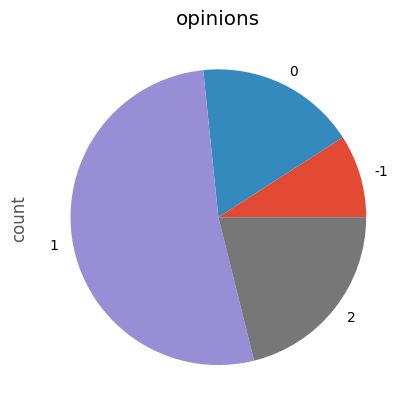

In [5]:
df['sentiment'].value_counts().sort_index() \
    .plot(kind='pie',
    title='opinions')


# Basic NLTK


In [6]:
example = df ['message'][101]
print(example)

RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦


In [7]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['RT',
 '@',
 'NatGeoChannel',
 ':',
 'Watch',
 '#',
 'BeforeTheFlood',
 'right',
 'here',
 ',']

# part of speach tokens


In [8]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('RT', 'NNP'),
 ('@', 'NNP'),
 ('NatGeoChannel', 'NNP'),
 (':', ':'),
 ('Watch', 'NNP'),
 ('#', '#'),
 ('BeforeTheFlood', 'NNP'),
 ('right', 'NN'),
 ('here', 'RB'),
 (',', ',')]

In [9]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  RT/NNP
  @/NNP
  NatGeoChannel/NNP
  :/:
  (PERSON Watch/NNP)
  #/#
  (ORGANIZATION BeforeTheFlood/NNP)
  right/NN
  here/RB
  ,/,
  as/IN
  @/NNP
  LeoDiCaprio/NNP
  travels/VBZ
  the/DT
  world/NN
  to/TO
  tackle/VB
  climate/NN
  change/NN
  https/NN
  :/:
  //t.co/LkDehj3tNn/NN
  httÃ¢â‚¬Â¦/NN)


# VADER


In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from tqdm import tqdm

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kaxiti/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# testing


In [11]:
sia.polarity_scores('i am devastated')

{'neg': 0.8, 'neu': 0.2, 'pos': 0.0, 'compound': -0.6124}

In [12]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

# Polarity on entire dataset


In [13]:
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['message']
    myid = row['id']
    res[myid] = sia.polarity_scores(text) 
   

  0%|          | 0/43943 [00:00<?, ?it/s]

100%|██████████| 43943/43943 [00:06<00:00, 6497.94it/s]


In [14]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(df, how='left')

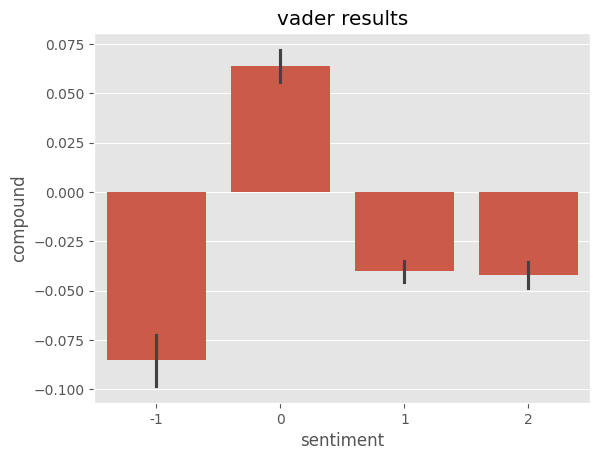

In [16]:
ax = sns.barplot(data=vaders, x='sentiment', y='compound')
ax.set_title('vader results')
plt.show()

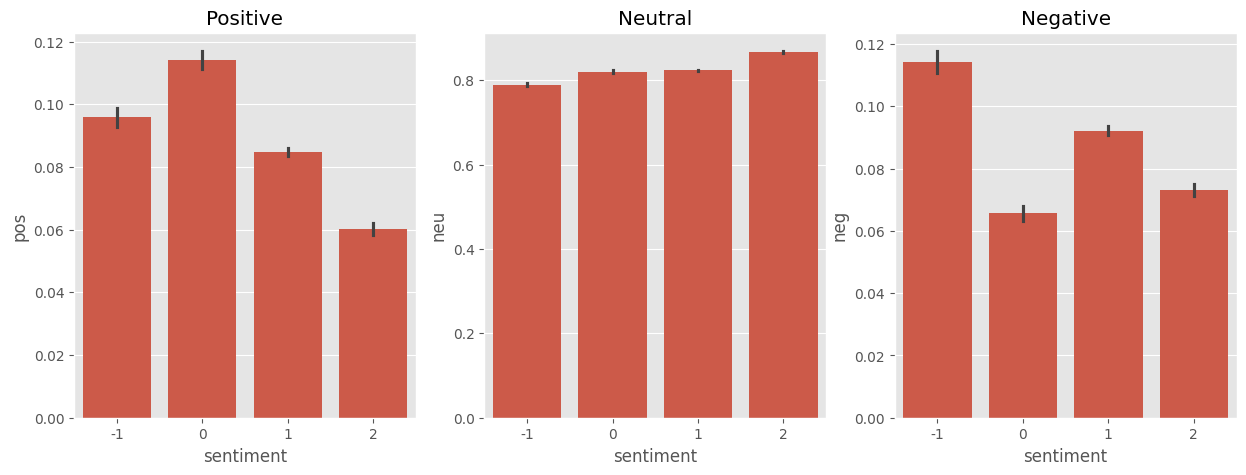

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='sentiment', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='sentiment', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='sentiment', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

# Roberta model

In [20]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

/home/kaxiti/Uni/ptihiaki/sentvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/home/kaxiti/Uni/ptihiaki/sentvenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
# run for roberta
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}

print(scores_dict)
print(example)

{'roberta_neg': 0.06654515, 'roberta_neu': 0.80191725, 'roberta_pos': 0.13153762}
RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦


In [42]:
# roberta function
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict


In [45]:
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['message']
        myid = row['id']
        vader_results = sia.polarity_scores(text) 
        vader_results_rename = {}
        for key, value in vader_results.items():
            vader_results_rename[f"vader_{key}"] = value    
            
        roberta_results = polarity_scores_roberta(text)
        both = {**roberta_results, **vader_results_rename}
        #res[myid] = both
        res[myid] = roberta_results
    except RuntimeError:
        print(f'broke for id {myid}')

  9%|▊         | 3795/43943 [02:47<27:24, 24.42it/s]

broke for id 3792


100%|██████████| 43943/43943 [30:48<00:00, 23.77it/s]


In [46]:
roberta_results = pd.DataFrame(res).T
roberta_results = roberta_results.reset_index().rename(columns={'index': 'id'})
roberta_results = roberta_results.merge(df, how='left')

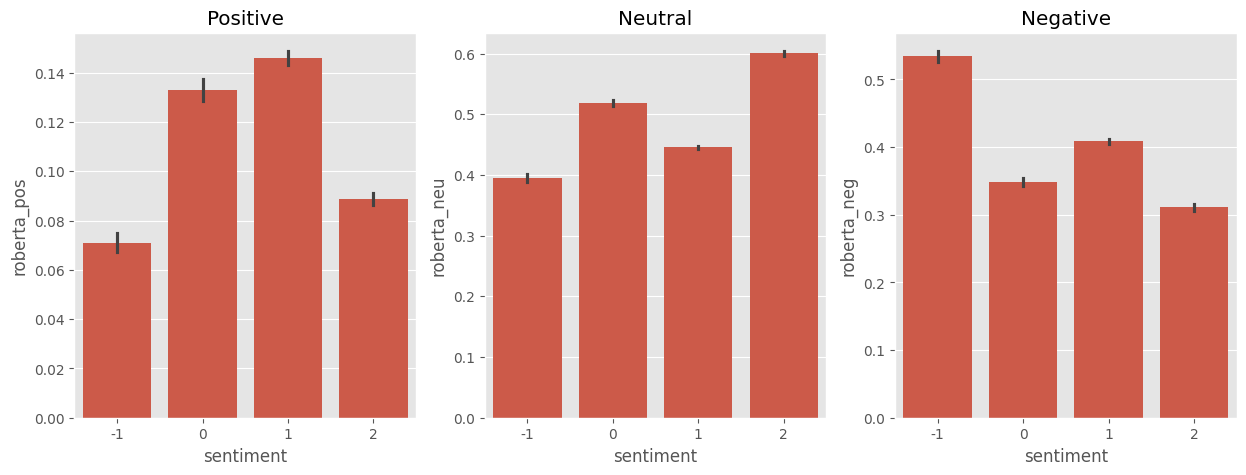

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=roberta_results, x='sentiment', y='roberta_pos', ax=axs[0])
sns.barplot(data=roberta_results, x='sentiment', y='roberta_neu', ax=axs[1])
sns.barplot(data=roberta_results, x='sentiment', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

In [25]:
both = {**roberta_results, **vader_results_rename}
both

{'roberta_neg': 0.3625049,
 'roberta_neu': 0.53443813,
 'roberta_pos': 0.10305706,
 'vader_neg': 0.0,
 'vader_neu': 0.722,
 'vader_pos': 0.278,
 'vader_compound': 0.7717}

# boberta results


In [31]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df, how='left')

In [32]:
results_df.head()

,id,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,vader_compound,sentiment,message,tweetid
0,1,0.070526,0.494236,0.435238,0.078,0.634,0.287,0.6428,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,2,0.066545,0.801917,0.131538,0.000,1.000,0.000,0.0000,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,3,0.001419,0.011799,0.986782,0.000,0.589,0.411,0.8544,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,4,0.003281,0.076678,0.920041,0.000,0.780,0.220,0.6705,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,5,0.184979,0.779431,0.035590,0.149,0.747,0.104,-0.2732,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [28]:
results_df.columns

Index(['id', 'roberta_neg', 'roberta_neu', 'roberta_pos', 'vader_neg',
       'vader_neu', 'vader_pos', 'vader_compound', 'sentiment', 'message',
       'tweetid'],
      dtype='object')

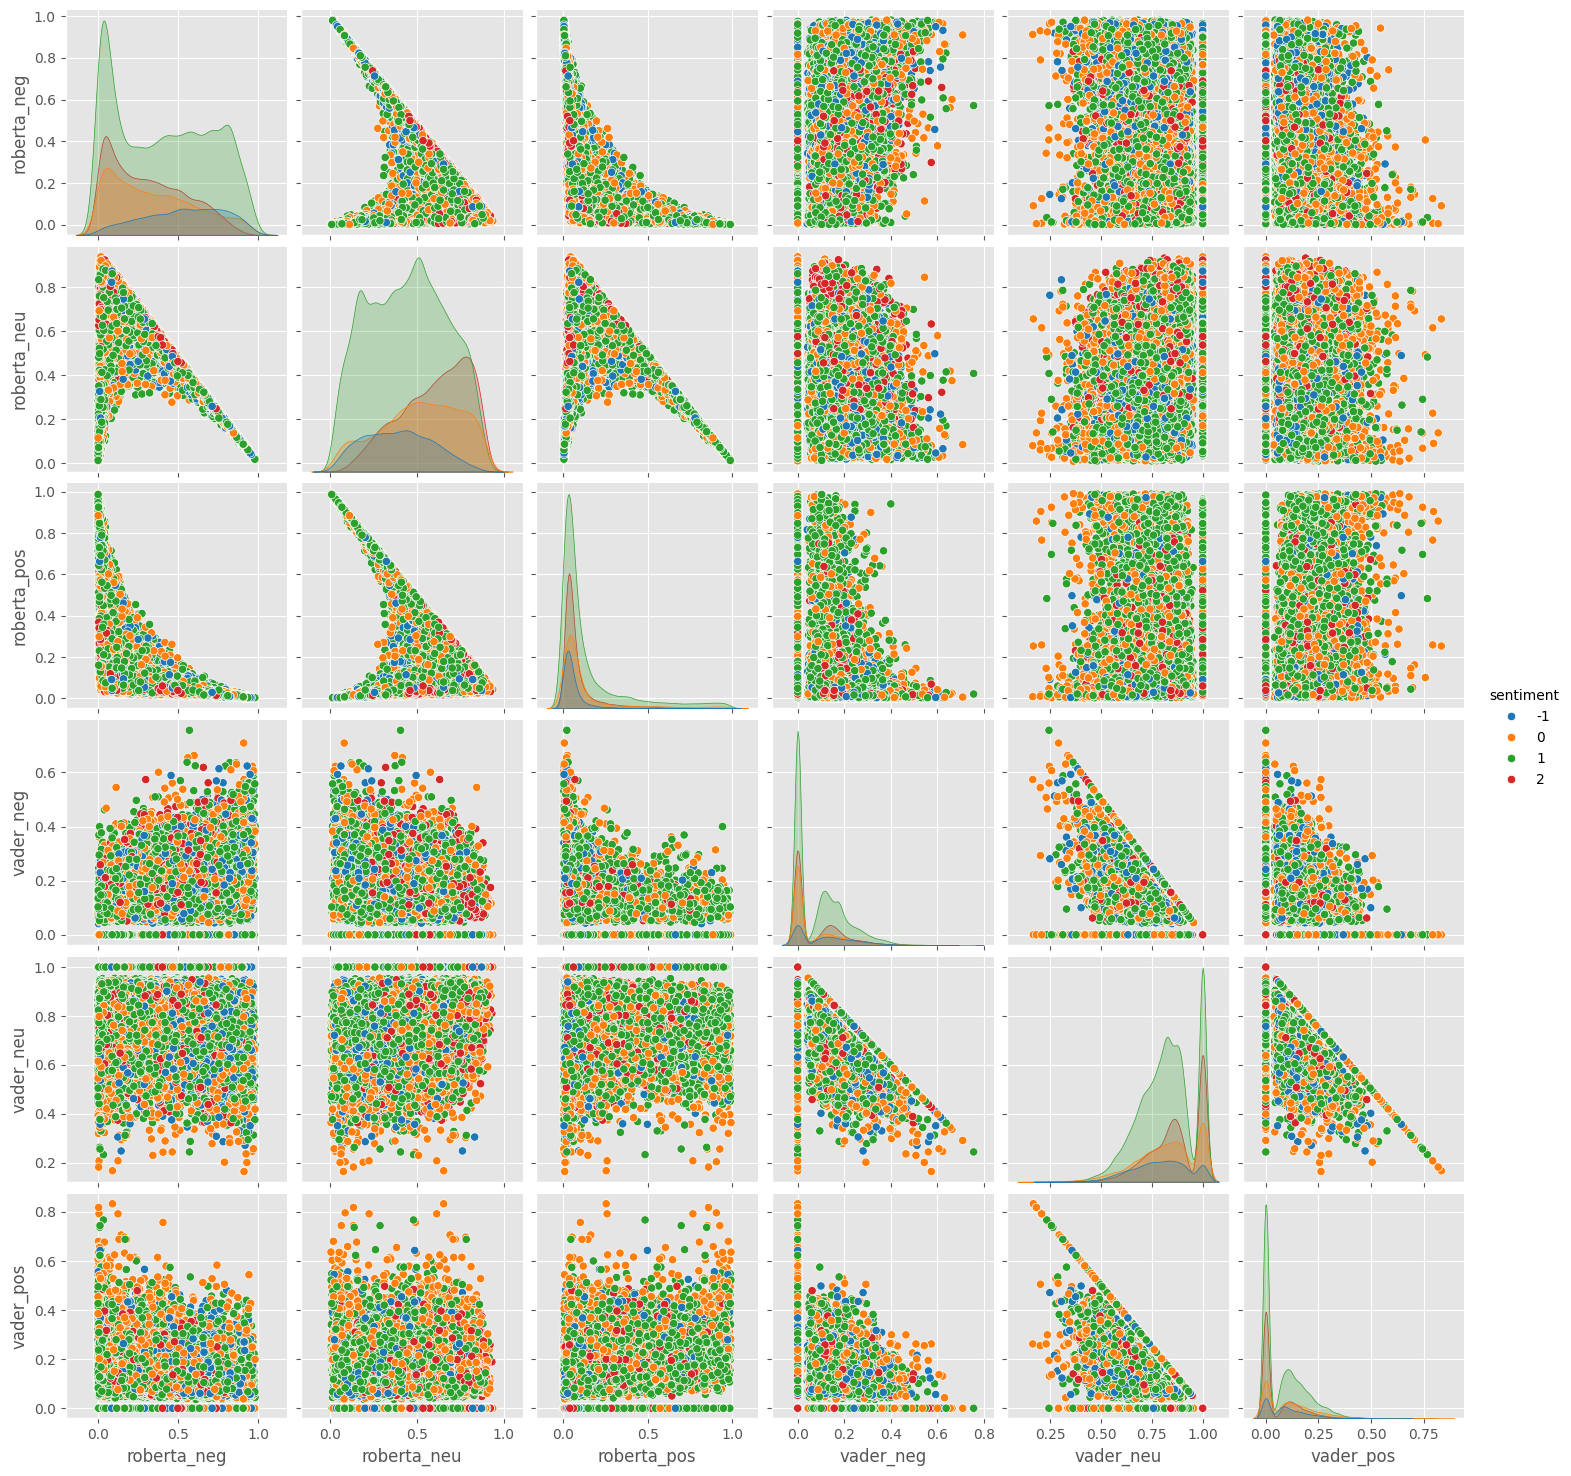

In [29]:
sns.pairplot(data=results_df, vars=['roberta_neg', 'roberta_neu', 'roberta_pos', 
             'vader_neg', 'vader_neu', 'vader_pos'],
             hue = 'sentiment',
             palette = 'tab10')
plt.show()